## Task 1: computing the area, the centroid, and the minimum bounding envelop of a simple polygon. 

In [37]:
import pandas as pd
import numpy as np
from shapely.geometry import Point

In [2]:
# Define point, polygon, area, centroid, envelop
class Point:
    def __init__(self,x,y):
        self.lon = x
        self.lat = y
        
class Polygon:
    def __init__(self, points = []):
        self.points = points

    def getArea(self):
        n = len(self.points)
        area = 0.0
        for i in range(n-1):
            area += ((self.points[i+1].lon * self.points[i].lat) - (self.points[i].lon * self.points[i+1].lat))
        return abs(area)/2
        return area
    
    def getCentroid(self):
        n = len(self.points)
        cx = cy = 0.0
        area = self.getArea()
        for i in range(n-1):
            value = ((self.points[i].lon * self.points[i+1].lat)-(self.points[i+1].lon * self.points[i].lat))
            cx += (self.points[i].lon + self.points[i+1].lon) * value
            cy += (self.points[i].lat + self.points[i+1].lat) * value
        cx = round(cx / (6 * area),2)
        cy = round(cy / (6 * area),2)
        return (cx, cy)
    
    def getEnvelop(self):
        min_lon = min([point.lon for point in self.points])
        min_lat = min([point.lat for point in self.points])
        max_lon = max([point.lon for point in self.points])
        max_lat = max([point.lat for point in self.points])
        return [(min_lon, min_lat), (max_lon, max_lat)]

In [3]:
if __name__ == '__main__':
    P1 = Point(2, 1)
    P2 = Point(3, 5)
    P3 = Point(6, 8)
    P4 = Point(1, 4)
    P5 = Point(1, 2)
    parcel= Polygon([P1,P2,P3,P4,P5])
    print(f"The area of given Multipoints is : {parcel.getArea()}")
    print(f"The centroid of obtained area is : {parcel.getCentroid()}")
    print(f'The Mimimum bounding envelope of polygon is: {parcel.getEnvelop()}')

The area of given Multipoints is : 7.5
The centroid of obtained area is : (1.98, 3.2)
The Mimimum bounding envelope of polygon is: [(1, 1), (6, 8)]


## Task -2: Collect 500 Flickr photos based on a geographic region, save the photo metadata in the CSV format. 

In [9]:
import flickrapi
import getpass
from datetime import date
import json

In [6]:
API_KEY = getpass.getpass("Enter your API Key")
API_SECRET = getpass.getpass("Enter your API Secret")

Enter your API Key ································
Enter your API Secret ················


In [7]:
# create the API class
flickr = flickrapi.FlickrAPI(API_KEY, API_SECRET, cache=True)

# retriving a set of photos within 15 km of the Disney World (28.377044063126185, -81.57033230607277)
photos = flickr.walk(lat=28.3770, lon=-81.5703, radius=15, extras='url_c', max_upload_date=str(date.today()))

# iterate photos in the photo set
photos_id_list = []
for i, photo_url in enumerate(photos):
    if i > 500: # only collect the first 50 photos
        break
        
    # get the photo url
    url = photo_url.get('url_c')
    url_id = photo_url.get('id')
    if url is not None:
        photos_id_list.append(url_id)
        
#print(photos_id_list)

In [13]:
# creating a list to store photo information
photo_list = []

for i in photos_id_list:
    photo_info = flickr.photos.getInfo(photo_id=i, format='json')
    photo_info_d = photo_info.decode()
    photo_info_l = json.loads(photo_info_d)
    user_info = flickr.people.getInfo(api_key = API_KEY, user_id = photo_info_l["photo"]["owner"]["nsid"], format = 'json')
    user_info_d = user_info.decode()
    user_info_l = json.loads(user_info_d)
    
    photo_id = photo_info_l ['photo']['id']
    latitude = photo_info_l ['photo'] ['location'] ['latitude']
    longitude = photo_info_l ['photo'] ['location'] ['longitude']
    taken_time = photo_info_l ['photo'] ['dates'] ['taken']
    url = photo_info_l ['photo'] ['urls'] ['url'][0] ['_content']
    user_id = photo_info_l ['photo'] ['owner'] ['nsid']
    username = photo_info_l ['photo'] ['owner'] ['username']
    realname = photo_info_l ['photo'] ['owner'] ['realname']
    registered_location = photo_info_l ['photo']['owner']['location']
    photos_count = user_info_l ['person'] ['photos'] ['count'] ['_content']
    
    tags = photo_info_l ['photo'] ['tags'] ['tag']
    if tags:
        user_tags = [tag['_content'] for tag in tags]
        #print(user_tags)
    else:
        user_tags = []
    
    #print(f'photo_id: {photo_id}, latitude: {latitude}, longitude: {longitude}, tags: {user_tags} , taken_time: {taken_time}, url: {url}, user_id: {user_id}, username: {username}, realname: {realname}, registered_location: {registered_location}, photos_count: {photos_count}')
    
    photo_list.append([photo_id, latitude, longitude, user_tags, taken_time, url, user_id, username, realname, registered_location, photos_count])

In [15]:
# Create a dataframe for the collected photos information
flickr_df = pd.DataFrame(photo_list, columns = ['photo_id', 'latitude', 'longitude', 'user_tags', 'taken_time', 'url', 'user_id', 'username', 'realname', 'registered_location', 'photos_count'])
#flickr_df.head()
flickr_df.to_csv('flickr_disney_world_photos.csv')

In [17]:
import geopandas as gpd

#Creating a flickr photos geodataframe
flickr_gdf = gpd.GeoDataFrame(data = flickr_df, geometry = gpd.points_from_xy(x = flickr_df.longitude, y = flickr_df.latitude, crs = 'EPSG:4326'))
flickr_gdf.head()

,photo_id,latitude,longitude,user_tags,taken_time,url,user_id,username,realname,registered_location,photos_count,geometry
0,52730288796,28.458472,-81.463745,[],2023-03-06 13:38:36,https://www.flickr.com/photos/29958880@N00/527...,29958880@N00,jonmc,Jon Mc,"Orlando, FL, United States",7202,POINT (-81.46375 28.45847)
1,52728419714,28.372627,-81.510223,"[vacation, travel]",2019-03-21 09:52:30,https://www.flickr.com/photos/197836684@N06/52...,197836684@N06,vDelboy,Dale Carter,None,1072,POINT (-81.51022 28.37263)
2,52728417939,28.410333,-81.461834,"[seaworld, orlando, vacation, travel]",2005-04-08 15:16:23,https://www.flickr.com/photos/197836684@N06/52...,197836684@N06,vDelboy,Dale Carter,None,1072,POINT (-81.46183 28.41033)
3,52723076532,28.356236,-81.562125,[disney202007],2020-07-17 09:39:48,https://www.flickr.com/photos/frankfranc/52723...,89451823@N08,FrankHPhillips,Frank Phillips,,2283,POINT (-81.56212 28.35624)
4,52724008210,28.356522,-81.561767,[disney202007],2020-07-17 09:04:24,https://www.flickr.com/photos/frankfranc/52724...,89451823@N08,FrankHPhillips,Frank Phillips,,2283,POINT (-81.56177 28.35652)


In [18]:
import matplotlib.pyplot as plt

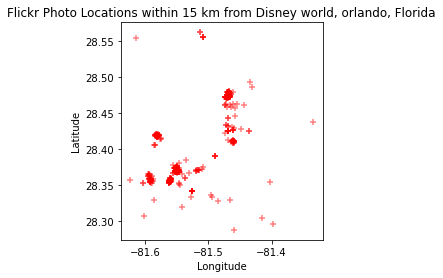

In [21]:
#flickr_gdf = flickr_gdf.to_crs(epsg = 4326) 

flickr_gdf.plot(color = 'red', marker = '+', alpha = 0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flickr Photo Locations within 15 km from Disney world, orlando, Florida')
plt.show()

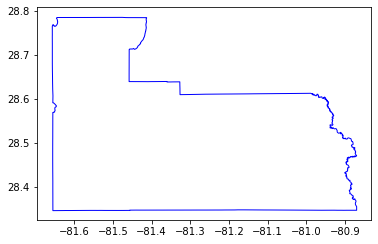

In [24]:
# read orange county, FL shape file

zipfile ='Orange_County_Boundary.zip'
orange_county = gpd.read_file(zipfile)
ax = orange_county.plot(color='white', edgecolor='blue')
plt.show()

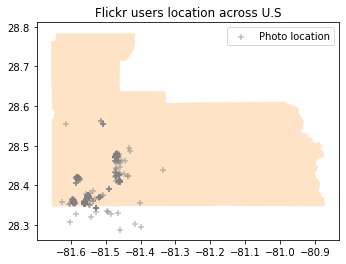

In [25]:
#locating flicker user location in orange county shapefile
ax = orange_county.plot(color='#ffe3c6', edgecolor='white')
flickr_gdf.plot(ax=ax, marker = '+', color='grey', label = 'Photo location', alpha = 0.5)

plt.title('Flickr photo locations around Disney World, Florida')
plt.legend()
plt.show()

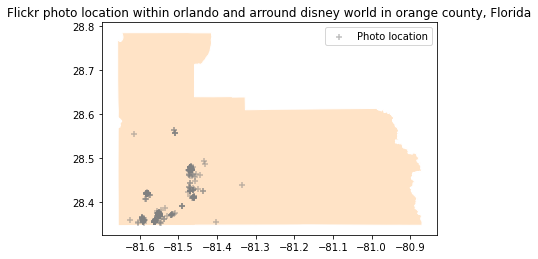

In [51]:
# plotting flicker photo within orange county

orange_gs = orange_county.geometry[0]    # convert geopandas geometry into geoseries
flickr_orange_gdf = flickr_gdf[flickr_gdf.within(orange_gs)]

ax = orange_county.plot(color='#ffe3c6', edgecolor='white')
flickr_orange_gdf.plot(ax=ax, marker = '+', color='grey', label = 'Photo location', alpha = 0.5)

plt.title('Flickr photo location within orlando and arround disney world in orange county, Florida')
plt.legend()
plt.show()

In [27]:
flickr_orange_gdf.to_csv('flickr_photos_within_orange_county_Disney_world_florida')

## Task 3: K means Clustering for Flickr photo locations

In [35]:
import random
import math

In [47]:
#creating empty list to store photos geomentry data
geom_data = []

for row in flickr_orange_gdf.itertuples():
    geom_data.append((float(row.longitude), float(row.latitude)))

In [48]:
#define a function which return random data point as the centroid for a cluster.
def get_random_centroid(data_points):
    return data_points[random.randint(0,len(data_points)-1)]

#define a function which computes the Euclidean distance between a point and a centroid.
def get_distance(point, centroid):
    distance = math.sqrt((point[0]-centroid[0])**2 + (point[1]-centroid[1])**2)
    return distance

# define a function to calculates the new centroid for a cluster by taking the mean of all the data points assigned to that cluster.
def update_centroid(data_points, cluster_labels, cluster_number):
    sum_x = 0
    sum_y = 0
    count = 0
    for point in data_points:
        if cluster_labels[point] == cluster_number:
            sum_x += point[0]
            sum_y += point[1]
            count += 1
    if count > 0:
        return (sum_x/count, sum_y/count)
    else:
        return get_random_centroid(data_points)

In [49]:
def KMeans_Clustering(k, max_iterations, data_points):
    centroids={} 
    cluster_labels = {} 
    
    for i in range (k):   # loop to initializes the centroids dictionary by assigning a random centroid to each cluster.
        centroids[i] = get_random_centroid(data_points)
        
    for j in range(max_iterations):   # loop to performs the KMeans clustering algorithm for the specified number of iterations.
        
        for eachpoint in data_points:  #  loop to assigns each data point to its nearest cluster by calculating the distance between the point and each centroid, and then assigning the point to the cluster with the closest centroid.
            dist_min = 99999999
            for i in range (k):
                distance=get_distance(eachpoint,centroids[i])
                if distance < dist_min:
                    dist_min=distance
                    cluster_labels[eachpoint]=i
        
       
        for i in range (k):   #loop to updates the centroids for each cluster by calculating the mean of the points assigned to that cluster, or by selecting a random data point if there are no points assigned to the cluster.
            centroids[i] = update_centroid(data_points, cluster_labels, i)
    return cluster_labels


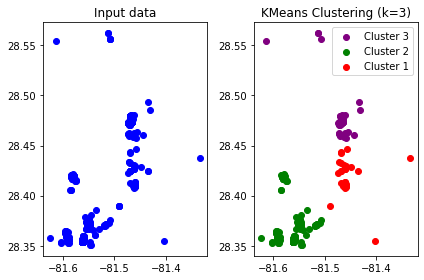

In [50]:
# Generate random data points
data_points = geom_data

# Perform KMeans clustering
k = 3
max_iterations = 100
cluster_labels = KMeans_Clustering(k, max_iterations, data_points)

# Separate the data points by their cluster label
clusters = {}
for point, label in cluster_labels.items():
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(point)

# Plot the input data points
plt.subplot(1,2,1)
x = [data[0] for data in data_points]
y = [data[1] for data in data_points]
plt.scatter(x, y, color='blue', label='Input Data')
plt.title('Input data')

# Plot the output clusters
plt.subplot(1,2,2)
colors = ['red', 'green', 'purple']
for label, points in clusters.items():
    x, y = [val[0] for val in points], [val[1] for val in points]
    plt.scatter(x, y, color=colors[label], label=f'Cluster {label+1}')

plt.title(f'KMeans Clustering (k={k})')
plt.legend()
plt.tight_layout()